# Testing the EIC pipeline

In [1]:
# define the pseudo-feedforward network abstracting the EIC core
import jax
import jax.numpy as jnp
import optax
import flax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from flax import linen as nn
from EICDense import *
from ShuffleBlocks import *
from Accumulator import *
from PseudoFFNet import *
from EICNet import *
from HelperFunctions.binary_trident_helper_functions import *
from HelperFunctions.binary_mnist_dataloader import *
from HelperFunctions.metric_functions import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

%load_ext autoreload
%autoreload 2



In [2]:
class Net(nn.Module):
    def setup(self):
        self.fc1 = EICDense(in_size = 1024, out_size = 2048, threshold = 0.0, noise_sd = 0.1, activation = custom_binary_gradient)
        self.ac1 = Accumulator(in_block_size = 2048//256, threshold = 0., noise_sd = 0.1, activation = custom_binary_gradient)
        self.fc2 = EICDense(in_size = 2048, out_size = 256, threshold = 0.0, noise_sd = 0.1, activation = custom_binary_gradient)
        self.ac2 = Accumulator(in_block_size = 1, threshold = 0., noise_sd = 0.1, activation = custom_binary_gradient)
        self.fc3 = EICDense(in_size = 256, out_size = 10, threshold = 0.0, noise_sd = 0.1, activation = custom_binary_gradient)
        self.ac3 = Accumulator(in_block_size = 1, threshold = 0., noise_sd = 0.1, activation = custom_binary_gradient)

    def __call__(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x

n1 = Net()
key = jax.random.key(0)
keys = jax.random.split(key, 10)
x = jax.random.normal(key, (10, 1024))
print(x.shape)
params = n1.init(key, x[0])

out = jax.vmap(lambda x, key: n1.apply(params, x, rngs = {"activation": key}))(x, keys)

print(out)

(10, 1024)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


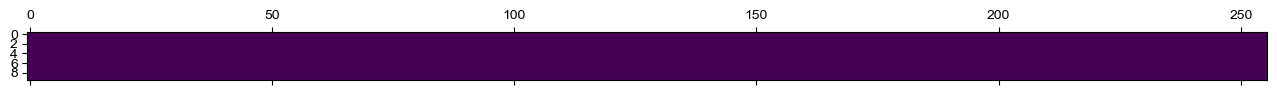

In [3]:
plt.matshow(out)

(10, 256)
(10, 256)


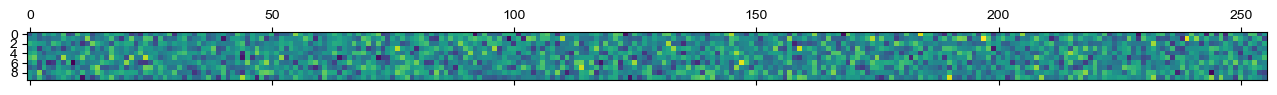

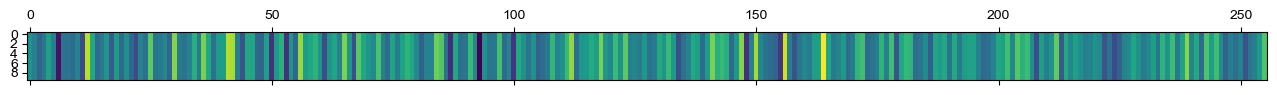

In [3]:
## test EIC Net
net = EICNet()
key = jax.random.key(0)
keys = jax.random.split(key, 10)
x = jax.random.normal(key, (10, 256))
print(x.shape)
params = net.init(key, x[0])

# Define the row-wise application function
def apply_row(x_row, key):
    return net.apply(params, x_row, rngs={"activation": key})

# Use vmap to apply the network row-wise
out = jax.vmap(apply_row)(x, keys)

print(out.shape)
plt.matshow(x)
plt.matshow(out)

In [ ]:
## accuracy function test: it works!
tar = jax.random.randint(key, (10,), 0, 10)
print(tar)

acc = accuracy(params, net, x, tar, keys)
print(acc)


[8 5 7 6 7 3 0 1 2 2]
0.1


In [15]:
## testing einsum
w_dum = jnp.zeros((4, 4, 2, 2))
x_dum = jnp.arange(4*2)
print(x_dum)

for i in range(4):
    for j in range(3):
        w_dum = w_dum.at[i, j].set(jnp.eye(2))

x_res = x_dum.reshape((2,4))
print(x_res)

# prod_dum = jnp.einsum('ijkl,')

[0 1 2 3 4 5 6 7]
[[0 1 2 3]
 [4 5 6 7]]


# Training pipeline

In [83]:
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"

def make_batches(inputs, targets, batch_size):
    """
    Make data batches for training.
    """

    num_samples = len(inputs)

    for i in range(0, num_samples, batch_size):
        yield inputs[i:i+batch_size], targets[i:i+batch_size]


def EIC_training_pipeline(
        data_path = DATA_PATH,
        batch_size = 128,
        learning_rate = 1e-4,
        epochs = 10
):

    """
    Training pipeline for EPIC-EIC model.
    """

    # initialize the model
    rng = jax.random.key(0)
    model = EICNet()

    # list of params
    params_list = []

    # load the data
    (train_inputs, train_labels), (val_inputs, val_labels), (test_inputs, test_labels) = load_and_process_mnist(data_path, binarize = True)

    params = model.init(rng, train_inputs[0].reshape(-1,))

    # optimizer = optax.sgd(learning_rate)
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params)

    # training loop
    for epoch in tqdm(range(epochs)):
        print("_________________________________________________")
        print(f"Epoch: {epoch+1}")

        # compute accuracy, if epoch = 1 we get the baseline accuracy
        train_acc_keys = jax.random.split(rng, train_inputs.shape[0])
        val_acc_keys = jax.random.split(rng, val_inputs.shape[0])
        test_acc_keys = jax.random.split(rng, test_inputs.shape[0])
        train_acc = accuracy(params, model, train_inputs, train_labels, train_acc_keys)
        val_acc = accuracy(params, model, val_inputs, val_labels, val_acc_keys)
        
        print(f"Train Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")
        print("_________________________________________________")

        # training
        for batch in make_batches(train_inputs, train_labels, batch_size):
            batch_images, batch_labels = batch
            keys = jax.random.split(rng, batch_images.shape[0])

            def loss_fn(params):
                logits = vmap(lambda img, key: model.apply(params, img, rngs = {"activation": key}))(batch_images, keys)
                return cross_entropy_loss(logits, batch_labels)

            loss, grads = jax.value_and_grad(loss_fn)(params)
            # print(grads)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            params_list.append(params)
    
    # copmute the test accuracy
    print("_________________________________________________")
    test_acc = accuracy(params, model, test_inputs, test_labels, test_acc_keys)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print("_________________________________________________")


    return params_list



In [84]:
eic_par = EIC_training_pipeline()

  0%|          | 0/10 [00:00<?, ?it/s]

_________________________________________________
Epoch: 1
Train Accuracy: 9.71%, Validation Accuracy: 9.87%
_________________________________________________
_________________________________________________
Epoch: 2
Train Accuracy: 9.93%, Validation Accuracy: 9.59%
_________________________________________________
_________________________________________________
Epoch: 3
Train Accuracy: 9.93%, Validation Accuracy: 9.59%
_________________________________________________
_________________________________________________
Epoch: 4
Train Accuracy: 9.93%, Validation Accuracy: 9.59%
_________________________________________________
_________________________________________________
Epoch: 5
Train Accuracy: 9.93%, Validation Accuracy: 9.59%
_________________________________________________
_________________________________________________
Epoch: 6
Train Accuracy: 9.93%, Validation Accuracy: 9.59%
_________________________________________________
______________________________________________

: 

In [66]:
p1 = eic_par[0]
p2 = eic_par[1]

w1 = p1['params']['fc2']['weights']
w2 = p2['params']['fc2']['weights']

plt.imshow(w2[0,0,:,:])
plt.colorbar()
    

KeyError: 'fc2'

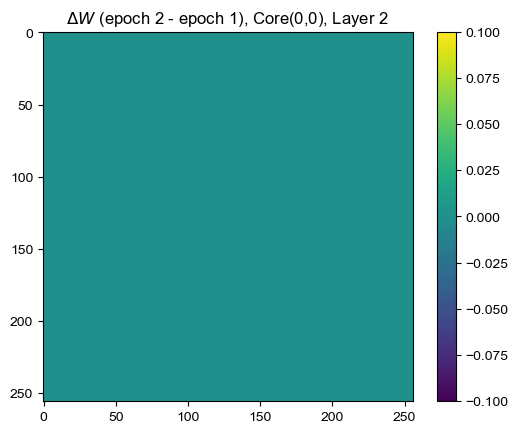

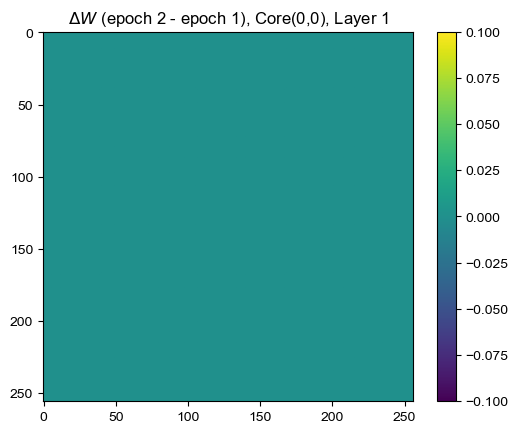

In [49]:
plt.figure()
w1 = p1['params']['fc2']['weights']
w2 = p2['params']['fc2']['weights']
plt.title(r"$\Delta W$ (epoch 2 - epoch 1), Core(0,0), Layer 2")
plt.imshow(w1[0,0] - w2[0,0])
plt.colorbar()

plt.figure()
w1 = p1['params']['fc1']['weights']
w2 = p2['params']['fc1']['weights']
plt.title(r"$\Delta W$ (epoch 2 - epoch 1), Core(0,0), Layer 1")
plt.imshow(w1[0,0] - w2[0,0])
plt.colorbar()

In [ ]:
for 

In [27]:
## testing loss
logits = jax.random.normal(key, (2, 256))
print(logits)

smax = jax.nn.log_softmax(logits, axis = -1)
print(smax)
print(jnp.argmax(smax, axis = -1))

tt = jax.random.randint(key, (2,), 0, 10)
oo = jax.nn.one_hot(tt, 256)

ce = -jnp.mean(jnp.sum(oo * smax, axis = -1))
ce

[[-2.0545669   0.33981755  0.2619878  -0.9536857   1.1861376   1.2227523
   0.1118008  -0.3273181  -0.35281932 -1.0937908  -0.4352797   1.4569159
   1.3426213   1.0477086   0.6277856   1.1544889   1.4039395   1.5889636
   0.15184146 -0.45450005  1.44212    -0.98234576  1.0387602   1.230129
   0.74546957 -1.193682    0.93348575 -0.21709861  0.82433665 -0.26893166
   0.08197741  0.28014636  2.2856433   0.85891354 -0.21806547 -1.4362359
  -0.75454265 -0.8940345   0.00396086  1.0566021   0.41683644  0.1684355
   0.98708355  0.28717148  0.38773963  0.42901424  0.24320975 -0.69616795
   0.20908484  0.514795   -0.2928037   0.01124914  1.0273975   1.1774498
   1.184416    0.38003933 -0.6792511  -1.7463572   0.8753063  -0.5320277
   0.06480394  0.2941306  -0.6533476   0.05776412 -0.3061082   0.9046162
   0.06861091  1.6166034  -0.31516266 -2.2512565  -0.68567014 -0.47716445
   0.37449017 -0.7146201   0.76217914  0.53276336  0.30647886 -0.65800744
  -1.5044358  -0.98599195  0.1525443  -0.0212507

Array(6.7392044, dtype=float32)